In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn import neighbors, metrics
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [2]:
# Import de tous mes dataframes

simple_data = pd.read_excel("../CSV-Excels/simple_data.xlsx", index_col=0)
large_simple_data = pd.read_excel("../CSV-Excels/large_simple_data.xlsx", index_col=0)
medium_data = pd.read_excel("../CSV-Excels/medium_data.xlsx", index_col=0)
large_medium_data = pd.read_excel("../CSV-Excels/large_medium_data.xlsx", index_col=0)
simple_data_with_energy_score = pd.read_excel("../CSV-Excels/simple_data_with_energy_score.xlsx", index_col=0)
medium_data_with_energy_score = pd.read_excel("../CSV-Excels/medium_data_with_energy_score.xlsx", index_col=0)
full_data_with_energy_score = pd.read_excel("../CSV-Excels/full_data_with_energy_score.xlsx", index_col=0)
full_data_without_energy_score = full_data_with_energy_score.drop(columns=['ENERGYSTARScore'])

In [4]:
# One hot encoding dataframes avec des variables catégorielles

full_data_without_energy_score = pd.get_dummies(full_data_without_energy_score)
full_data_with_energy_score = pd.get_dummies(full_data_with_energy_score)
large_simple_data = pd.get_dummies(large_simple_data)
large_medium_data = pd.get_dummies(large_medium_data)

In [5]:
# Set name for each dataframe

full_data_without_energy_score.name = 'full_data_without_energy_score'
full_data_with_energy_score.name = 'full_data_with_energy_score'
simple_data.name = 'simple_data'
large_simple_data.name = 'large_simple_data'
medium_data.name = 'medium_data'
large_medium_data.name = 'large_medium_data'
simple_data_with_energy_score.name = 'simple_data_with_energy_score'
medium_data_with_energy_score.name = 'medium_data_with_energy_score'

In [5]:
# Split data in train set and test set

def split_data(dataframe, target_variable, train_sizing):
    X = dataframe[dataframe.columns.difference(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'])].values
    y = dataframe[target_variable].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_sizing, random_state=33530)
    return X_train, X_test, y_train, y_test

In [6]:
# Scaler uniquement sur les variables quantitatives spécifiées 

def scaler_fit(scaler, df):
    if df.name == 'simple_data' or df.name == 'large_simple_data':
        df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']] = scaler.fit_transform(df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']])
    elif df.name == 'medium_data' or df.name == 'large_medium_data':
        df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']] = scaler.fit_transform(df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']])
    elif df.name == 'simple_data_with_energy_score':
        df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']] = scaler.fit_transform(df[['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']])
    elif df.name == 'medium_data_with_energy_score':
        df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']] = scaler.fit_transform(df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']])
    elif df.name == 'full_data_with_energy_score':
        df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = scaler.fit_transform(df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']])
    elif df.name == 'full_data_without_energy_score':
        df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = scaler.fit_transform(df[['NumberOfUseTypes', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']])
    return df

In [155]:
# random regressor

def random_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test):

    y_pred_random = np.random.randint(np.min(y_train), np.max(y_train), y_test.shape)
    random_rmse = metrics.mean_squared_error(y_test, y_pred_random, squared=False)
    random_r2 = metrics.r2_score(y_test, y_pred_random)
    random_max_error = metrics.max_error(y_test, y_pred_random)
    
    return {'dataset': dataframe.name, 'model': 'Random', 'tested_hyperparameters': 'aucun', 'RMSE': random_rmse,
            'best_hyperparameters': 'aucun', 'r2_test': random_r2, 'max_error': random_max_error}

In [156]:
# dummy regressor

def dummy_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test):
    
    dum = DummyRegressor(strategy='mean')
    dum.fit(X_train_scaled, y_train)
    y_pred_dum = dum.predict(X_test_scaled)
    
    rmse = metrics.mean_squared_error(y_test, y_pred_dum, squared=False)
    r2 = metrics.r2_score(y_test, y_pred_dum)
    max_error = metrics.max_error(y_test, y_pred_dum)
    
    return {'dataset': dataframe.name, 'model': 'DummyRegressor', 'best_hyperparameters': 'aucun',
            'tested_hyperparameters': 'aucun', 'RMSE': rmse, 'max_error': max_error, 'r2_test': r2}

In [157]:
# knn regressor

def knn_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):
    
    grid = GridSearchCV(
        neighbors.KNeighborsRegressor(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'KnnRegressor', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [158]:
def ridge_regression(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):
    
    grid = GridSearchCV(
        Ridge(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan

    return {'dataset': dataframe.name, 'model': 'Ridge Regression', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [159]:
def lasso_regression(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        Lasso(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'Lasso Regression', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [160]:
def kernel_ridge(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        KernelRidge(kernel='rbf'),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'Kernel Ridge Regression', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [161]:
def kernel_svr(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        SVR(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'Kernel SVR', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [162]:
def mlp_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        MLPRegressor(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    index_max_score = np.where(grid_results['mean_test_score'] == np.amax(grid_results['mean_test_score']))
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'MLP Regressor', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [163]:
def gboost_regressor(dataframe, X_train_scaled, X_test_scaled, y_train, y_test, hyperparameters, score):

    grid = GridSearchCV(
        GradientBoostingRegressor(),
        hyperparameters,
        cv=5,
        scoring=score,
        return_train_score=True
    )
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    y_pred = grid.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    grid_results = grid.cv_results_
    arr = grid_results['mean_test_score'][grid_results['mean_test_score'] > -2]
    max_score = np.amax(arr)
    index_max_score = np.where(grid_results['mean_test_score'] == max_score)
    if len(index_max_score) > 0:
        mean_train_score = grid_results['mean_train_score'][index_max_score[0][0]]
        mean_test_score = grid_results['mean_test_score'][index_max_score[0][0]]
    else:
        mean_train_score = np.nan
        mean_test_score = np.nan
    
    return {'dataset': dataframe.name, 'model': 'GBoost Regressor', 'tested_hyperparameters': str(hyperparameters),
            'best_hyperparameters': best_params, 'r2_trainset': mean_train_score,
            'r2_validation_set': mean_test_score, 'r2_test': r2, 'RMSE': rmse, 'max_error': max_error
           }

In [9]:
# Variables

TARGET = "SiteEnergyUse(kBtu)"
TRAIN_SIZE = 0.7
df_list = [simple_data, large_simple_data, medium_data, large_medium_data, simple_data_with_energy_score,
           medium_data_with_energy_score, full_data_without_energy_score, full_data_with_energy_score]

In [165]:
# Set name for each dataframe

full_data_without_energy_score.name = 'full_data_without_energy_score'
full_data_with_energy_score.name = 'full_data_with_energy_score'
simple_data.name = 'simple_data'
large_simple_data.name = 'large_simple_data'
medium_data.name = 'medium_data'
large_medium_data.name = 'large_medium_data'
simple_data_with_energy_score.name = 'simple_data_with_energy_score'
medium_data_with_energy_score.name = 'medium_data_with_energy_score'

In [166]:
# Création du dataframe final qui stocke les résultats des modèles

d = pd.DataFrame(columns = [ "dataset", "scaler_used", "model", "tested_hyperparameters",
                            "best_hyperparameters", "r2_trainset", "r2_validation_set",
                            "r2_test", "RMSE", "max_error" 
                           ])

scaler_counter = 0
start_row = 0
end_row = 9
string_scaler_list = ['StandardScaler', 'RobustScaler', 'MinMaxScaler']
scaler_list = [StandardScaler(), RobustScaler(), MinMaxScaler()]
for df in df_list:
    for scaler in scaler_list:
        scaled_dataframe = scaler_fit(scaler, df)
        X_train_scaled, X_test_scaled, y_train, y_test = split_data(scaled_dataframe, TARGET, TRAIN_SIZE)
        d = d.append([
            random_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test),
            dummy_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test),
            knn_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test, {'n_neighbors': [3,5,7,9,11,13,15]}, 'r2'),
            ridge_regression(df, X_train_scaled, X_test_scaled, y_train, y_test, {'alpha': np.logspace(-3, 3, 7), 'max_iter': [10000], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}, 'r2'),
            lasso_regression(df, X_train_scaled, X_test_scaled, y_train, y_test, {'alpha': np.logspace(-3, 3, 7), 'max_iter': [5000], 'selection': ['cyclic', 'random'], 'random_state': [33530]}, 'r2'),
            kernel_ridge(df, X_train_scaled, X_test_scaled, y_train, y_test, {'alpha': np.logspace(-3, 3, 7), 'gamma': np.logspace(-2, 2, 5)}, 'r2'),
            kernel_svr(df, X_train_scaled, X_test_scaled, y_train, y_test, {'C':  np.logspace(-1, 2, 3), 'gamma': np.logspace(-1, 1, 3), 'kernel': ['rbf']}, 'r2'),
            mlp_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test, {'alpha': np.logspace(-2, 1, 4), 'learning_rate_init': np.logspace(-3,-2,2), 'learning_rate': ['constant'], 'hidden_layer_sizes': [(20,20)], 'activation': ['relu'], 'solver': ['adam'], 'random_state': [33530], 'max_iter': [2000]}, 'r2'),
            gboost_regressor(df, X_train_scaled, X_test_scaled, y_train, y_test, {'n_estimators': [100,150], 'learning_rate': [0.03,0.01], 'loss': ['huber'], 'max_depth': [3,6], 'random_state': [33530]}, 'r2')
        ], ignore_index=True)
        d.iloc[start_row:end_row,1] = string_scaler_list[scaler_counter]
        scaler_counter += 1
        start_row += 9
        end_row += 9
    scaler_counter = 0

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0210993116814112e+16, tolerance: 125191559008645.2
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6028117290413488.0, tolerance: 32077379302643.516
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.473615700748112e+16, tolerance: 116007638812739.48
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1055224442618501e+17, tolerance: 121419228454927.14
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.207205163507722e+16, tolerance: 32077379302643.516
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2505605278829008e+17, tolerance: 116007638812739.48
Objective did not co

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1055246349126125e+17, tolerance: 121419228454927.14
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.2072205912823176e+16, tolerance: 32077379302643.516
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2505621981239792e+17, tolerance: 116007638812739.48
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2898723949750138e+17, tolerance: 126335144519940.4
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6028556093938080.0, tolerance: 32077379302643.516
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1055439877104309e+17, tolerance: 121419228454927.14
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.207358393171392e+16, 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.765793175887526e+16, tolerance: 121419228454927.14
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9703902882495944e+16, tolerance: 32077379302643.516
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.215440146210157e+16, tolerance: 116007638812739.48
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0841497307842547e+17, tolerance: 126335144519940.4
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.019041479374144e+16, tolerance: 125191559008645.2
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7626618089137696.0, tolerance: 121419228454927.14
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.38663935187302e+16, toler

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.678437899008563e+16, tolerance: 116007638812739.48
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0841499848618725e+17, tolerance: 126335144519940.4
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0190420406091232e+16, tolerance: 125191559008645.2
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7626621512458880.0, tolerance: 121419228454927.14
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3866400231978376e+16, tolerance: 32077379302643.516
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0015060847878944e+16, tolerance: 116007638812739.48
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.611631875013296e+16, to

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.970396967885512e+16, tolerance: 32077379302643.516
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.215446314502486e+16, tolerance: 116007638812739.48
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0841508684938317e+17, tolerance: 126335144519940.4
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.019066156542464e+16, tolerance: 125191559008645.2
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7626843903694176.0, tolerance: 121419228454927.14
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3866748585342e+16, tolerance: 32077379302643.516
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.611671705046688e+16, toleran

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9644765999896

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1774611170063516e+16, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0078150427106088e+16, tolerance: 38684804476935.18
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7147975789300332.0, tolerance: 43063960330298.984
Objective did not converge. You might want to increase the number of iterations. Duality gap: 452326314520541.0, tolerance: 22794020148916.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2026932151024256.0, tolerance: 45192149507681.625
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4788167379955444e+16, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4449596478270586e+16, tolerance: 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4946760302807186e+16, tolerance: 38684804476935.18
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.916674264839704e+16, tolerance: 43063960330298.984
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3399975760700375.0, tolerance: 22794020148916.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.834431251498107e+16, tolerance: 45192149507681.625
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.203181784393352e+16, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1450075746069776e+16, tolerance: 38684804476935.18
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5185203220097816e+16, toler

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.922147376808151e+16, tolerance: 45192149507681.625
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.628325504117782e+16, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5238143109244324e+16, tolerance: 38684804476935.18
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.908175323284257e+16, tolerance: 43063960330298.984
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2701498091736963.0, tolerance: 22794020148916.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.831129095802377e+16, tolerance: 45192149507681.625
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0321895062281468e+16, toler

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3736373505863816e+16, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0491974146574748e+16, tolerance: 38684804476935.18
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1285057137959904e+16, tolerance: 43063960330298.984
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2516050988017585.5, tolerance: 22794020148916.84
Objective did not c

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1941753390649368.0, tolerance: 45192149507681.625
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8800104647990120.0, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3631955266682248e+16, tolerance: 38684804476935.18
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5735793068640698e+16, tolerance: 43063960330298.984
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2542347734130691.0, tolerance: 22794020148916.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7096770705414248.0, tolerance: 45192149507681.625
Objective did not converge. You might want to increase the number of iterations. Duality gap: 123927153681252.0, tolerance: 3868480

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9614486276574224e+16, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.04920294139413e+16, tolerance: 38684804476935.18
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3994250325856864e+16, tolerance: 43063960330298.984
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2511403098713964.5, tolerance: 22794020148916.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.728444430246908e+16, tolerance: 45192149507681.625
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.562339719453291e+16, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3589913769503784e+16, tolera

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
Stochastic

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9955428214910972.0, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7024689818787306.0, tolerance: 38684804476935.18
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6302432209568236.0, tolerance: 43063960330298.984
Objective did not converge. You might want to increase the number of iterations. Duality gap: 529115140568598.5, tolerance: 22794020148916.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.047049456805916e+16, tolerance: 45192149507681.625
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.910523663550307e+16, tolerance: 37086732277600.84
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2359871546280952e+16, tolerance: 386848

In [167]:
d

,dataset,scaler_used,model,tested_hyperparameters,best_hyperparameters,r2_trainset,r2_validation_set,r2_test,RMSE,max_error
0,simple_data,StandardScaler,Random,aucun,aucun,NaN,NaN,-557.450736,5.083809e+08,8.726559e+08
1,simple_data,StandardScaler,DummyRegressor,aucun,aucun,NaN,NaN,-0.001179,2.152547e+07,2.839564e+08
2,simple_data,StandardScaler,KnnRegressor,"{'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}",{'n_neighbors': 5},0.396415,0.117967,0.191821,1.933974e+07,2.554776e+08
3,simple_data,StandardScaler,Ridge Regression,"{'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+0...","{'alpha': 0.1, 'max_iter': 10000, 'solver': 's...",0.675762,0.513188,0.514106,1.499573e+07,1.984480e+08
4,simple_data,StandardScaler,Lasso Regression,"{'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+0...","{'alpha': 1000.0, 'max_iter': 5000, 'random_st...",0.676452,0.506384,0.520412,1.489810e+07,1.973767e+08
...,...,...,...,...,...,...,...,...,...,...
211,full_data_with_energy_score,MinMaxScaler,Lasso Regression,"{'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+0...","{'alpha': 1000.0, 'max_iter': 5000, 'random_st...",0.901465,-0.431582,0.718925,1.360565e+07,1.097020e+08
212,full_data_with_energy_score,MinMaxScaler,Kernel Ridge Regression,"{'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+0...","{'alpha': 0.001, 'gamma': 0.01}",0.994973,0.362610,0.274667,2.185630e+07,2.306533e+08
213,full_data_with_energy_score,MinMaxScaler,Kernel SVR,"{'C': array([ 0.1 , 3.16227766, 100. ...","{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}",-0.053181,-0.073426,-0.064176,2.647371e+07,2.903376e+08
214,full_data_with_energy_score,MinMaxScaler,MLP Regressor,"{'alpha': array([ 0.01, 0.1 , 1. , 10. ]),...","{'activation': 'relu', 'alpha': 1.0, 'hidden_l...",0.094574,0.100125,0.001802,2.563990e+07,2.842842e+08


In [1]:
# récupérer les meilleurs modèles

d.sort_values(by='r2_validation_set', ascending=False, inplace=True)
d.head()

# Je choisis le xgboost sur mon dataframe complet
# Je vais entrainer mes modèles sur les dataframes avec et sans energy star score

In [10]:
# gboost full_data_without_energy_score
final_df_without_energy_score = pd.read_excel("../CSV-Excels/full_data_with_energy_score.xlsx", index_col=0)
final_df_without_energy_score = final_df_without_energy_score[(final_df_without_energy_score["PrimaryPropertyType"] != 'Low-Rise Multifamily') & (final_df_without_energy_score["LargestPropertyUseType"] != 'Multifamily Housing')]
final_df_without_energy_score['SiteEnergyUse(kBtu)'] = np.log10(final_df_without_energy_score['SiteEnergyUse(kBtu)'])
final_df_without_energy_score.drop(columns=["ENERGYSTARScore"], inplace=True)
final_df_without_energy_score = pd.get_dummies(final_df_without_energy_score)
final_df_without_energy_score.name = 'full_data_without_energy_score'

final_df_without_energy_score_scaled = scaler_fit(RobustScaler(), final_df_without_energy_score)
X_train_scaled, X_test_scaled, y_train, y_test = split_data(final_df_without_energy_score_scaled, TARGET, TRAIN_SIZE)

grid_gboost_without_energy_score = GridSearchCV(
        GradientBoostingRegressor(),
        {'n_estimators': [150], 'learning_rate': [0.03,0.01], 'loss': ['huber'], 'max_depth': [6,9], 'random_state': [33530]},
        cv=5,
        scoring='r2',
        return_train_score=True
    )
grid_gboost_without_energy_score.fit(X_train_scaled, y_train)
best_params = grid_gboost_without_energy_score.best_params_
y_pred = grid_gboost_without_energy_score.predict(X_test_scaled)
r2 = metrics.r2_score(10**y_test, 10**y_pred)
print(r2)
print(best_params)
grid_gboost_without_energy_score.cv_results_
# r2 validation = 0.55
# r2 test = 0.70
# r2 train = 0.86

# avec log10
# r2 validation = 0.78
# r2 test = 0.81
# r2 train = 0.95

0.8184578790982778
{'learning_rate': 0.03, 'loss': 'huber', 'max_depth': 6, 'n_estimators': 150, 'random_state': 33530}


{'mean_fit_time': array([1.82528214, 5.3673696 , 2.13247352, 6.33078918]),
 'std_fit_time': array([0.03210952, 0.17832279, 0.05484793, 0.12179085]),
 'mean_score_time': array([0.00107965, 0.00160375, 0.00108175, 0.00166402]),
 'std_score_time': array([1.25527017e-04, 5.28041124e-05, 4.98926183e-05, 1.12519890e-04]),
 'param_learning_rate': masked_array(data=[0.03, 0.03, 0.01, 0.01],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_loss': masked_array(data=['huber', 'huber', 'huber', 'huber'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[6, 9, 6, 9],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[150, 150, 150, 150],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_random_state': m

In [21]:
features_imp = grid_gboost_without_energy_score.best_estimator_.feature_importances_
features_names = final_df_without_energy_score.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']).columns

importances = pd.DataFrame(data={
    'Variable': features_names,
    'Importance': features_imp
})
importances = importances.sort_values(by='Importance', ascending=False)
most_important_features = importances.head(10)
most_important_features.reset_index()

,index,Variable,Importance
0,46,LargestPropertyUseType_Refrigerated Warehouse,0.641682
1,44,LargestPropertyUseType_Other,0.067259
2,22,PrimaryPropertyType_Medical Office,0.042862
3,42,LargestPropertyUseType_Non-Refrigerated Warehouse,0.040587
4,115,ThirdLargestPropertyUseType_Worship Facility,0.036800
5,41,LargestPropertyUseType_Medical Office,0.035886
6,4,PropertyGFAParking,0.032360
7,14,BuildingType_NonResidential,0.016454
8,113,ThirdLargestPropertyUseType_Social/Meeting Hall,0.013638
9,7,SecondLargestPropertyUseTypeGFA,0.006773


In [13]:
# gboost full_data_with_energy_score
final_df_with_energy_score = pd.read_excel("../CSV-Excels/full_data_with_energy_score.xlsx", index_col=0)
final_df_with_energy_score = final_df_with_energy_score[(final_df_with_energy_score["PrimaryPropertyType"] != 'Low-Rise Multifamily') & (final_df_with_energy_score["LargestPropertyUseType"] != 'Multifamily Housing')]
final_df_with_energy_score['SiteEnergyUse(kBtu)'] = np.log10(final_df_with_energy_score['SiteEnergyUse(kBtu)'])
final_df_with_energy_score = pd.get_dummies(final_df_with_energy_score)
final_df_with_energy_score.name = 'full_data_with_energy_score'

final_df_with_energy_score_scaled = scaler_fit(RobustScaler(), final_df_with_energy_score)
X_train_scaled, X_test_scaled, y_train, y_test = split_data(final_df_with_energy_score_scaled, TARGET, TRAIN_SIZE)

grid_gboost_with_energy_score = GridSearchCV(
        GradientBoostingRegressor(),
        {'n_estimators': [150,200], 'learning_rate': [0.03,0.01], 'loss': ['huber'], 'max_depth': [6,9], 'random_state': [33530]},
        cv=10,
        scoring='r2',
        return_train_score=True
    )
grid_gboost_with_energy_score.fit(X_train_scaled, y_train)
best_params = grid_gboost_with_energy_score.best_params_
y_pred = grid_gboost_with_energy_score.predict(X_test_scaled)

r2 = metrics.r2_score(10**y_test, 10**y_pred)
print(r2)
print(best_params)
grid_gboost_with_energy_score.cv_results_
# r2 validation = 0.63
# r2 test = 0.80
# r2 train = 0.74

# avec log10
# r2 validation = 0.86
# r2 test = 0.89
# r2 train = 0.97

0.8985902560179935
{'learning_rate': 0.03, 'loss': 'huber', 'max_depth': 6, 'n_estimators': 200, 'random_state': 33530}


{'mean_fit_time': array([2.04703491, 2.51970294, 6.74459484, 8.03372197, 2.23607965,
        2.97601624, 7.447838  , 9.88572209]),
 'std_fit_time': array([0.05578145, 0.04779655, 0.19566411, 0.19480815, 0.04315192,
        0.0576695 , 0.16310999, 0.23600877]),
 'mean_score_time': array([0.00080037, 0.00086205, 0.00118303, 0.00139444, 0.00076962,
        0.00089219, 0.00114839, 0.00140429]),
 'std_score_time': array([3.44088482e-05, 1.16440324e-05, 3.43461803e-05, 2.88052765e-05,
        2.35412240e-05, 2.74950380e-05, 4.15855656e-05, 4.08911148e-05]),
 'param_learning_rate': masked_array(data=[0.03, 0.03, 0.03, 0.03, 0.01, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_loss': masked_array(data=['huber', 'huber', 'huber', 'huber', 'huber', 'huber',
                    'huber', 'huber'],
              mask=[False, False, False, False, False, False, False, False],
        fill_valu

In [29]:
features_imp = grid_gboost_with_energy_score.best_estimator_.feature_importances_
features_names = final_df_with_energy_score.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']).columns

importances = pd.DataFrame(data={
    'Variable': features_names,
    'Importance': features_imp
})
importances = importances.sort_values(by='Importance', ascending=False)
importances.reset_index(inplace=True)
most_important_features = importances.head(10)
most_important_features

,index,Variable,Importance
0,47,LargestPropertyUseType_Refrigerated Warehouse,0.626670
1,4,PropertyGFAParking,0.082887
2,45,LargestPropertyUseType_Other,0.046509
3,43,LargestPropertyUseType_Non-Refrigerated Warehouse,0.043191
4,42,LargestPropertyUseType_Medical Office,0.040475
5,23,PrimaryPropertyType_Medical Office,0.035585
6,5,PropertyGFABuilding(s),0.031336
7,15,BuildingType_NonResidential,0.013952
8,116,ThirdLargestPropertyUseType_Worship Facility,0.011737
9,114,ThirdLargestPropertyUseType_Social/Meeting Hall,0.011429


In [30]:
importances[importances['Variable'] == "ENERGYSTARScore"]

,index,Variable,Importance
10,9,ENERGYSTARScore,0.007324


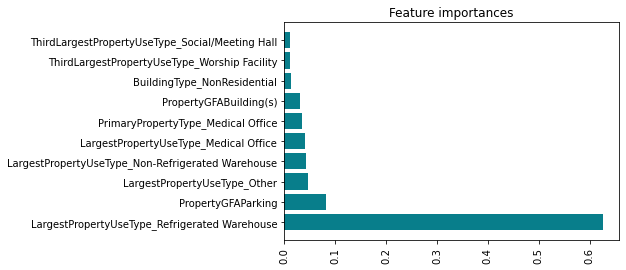

In [23]:
plt.barh(most_important_features['Variable'], most_important_features['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

In [17]:
# Test librairie shap

import shap
X_importance = final_df_with_energy_score.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']).values
X_importance

array([[ 1.927e+03,  0.000e+00,  2.250e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 1.996e+03,  0.000e+00,  2.000e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 1.969e+03,  0.000e+00,  9.500e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       ...,
       [ 1.955e+03,  0.000e+00, -5.000e-01, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 1.929e+03,  0.000e+00, -2.500e-01, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 2.015e+03,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00]])

In [18]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(grid_gboost_with_energy_score.best_estimator_)
shap_values = explainer.shap_values(X_importance)

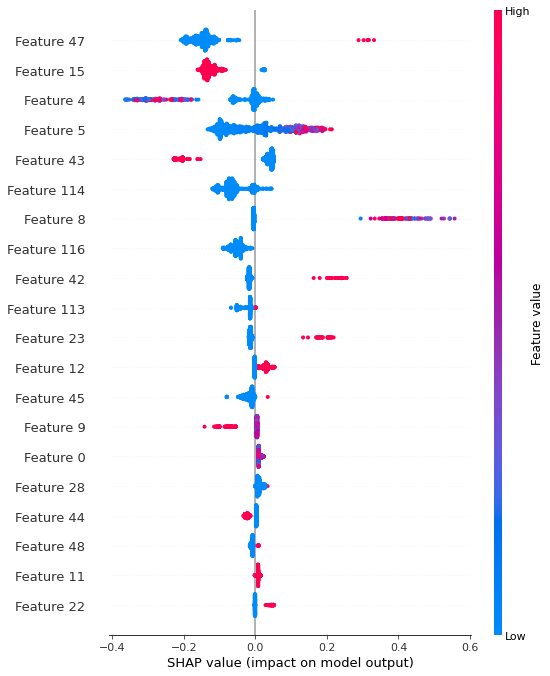

In [19]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

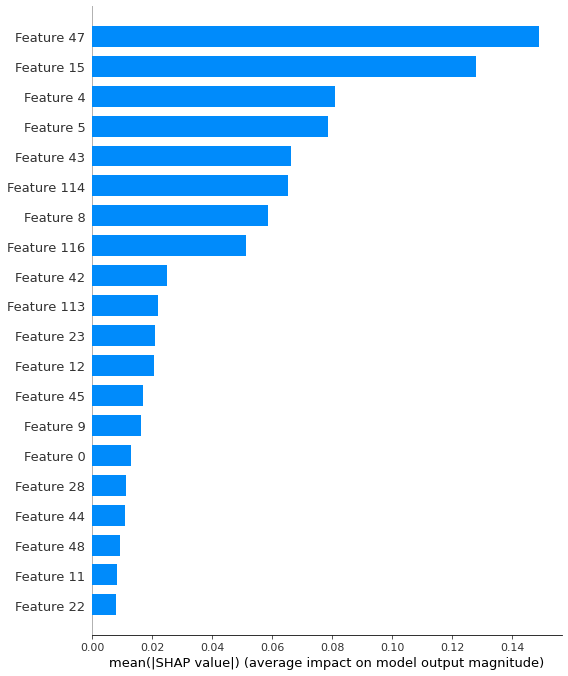

In [20]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')